In [176]:
import cv2
import numpy as np
from PIL import Image
from PIL import ImageFilter
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import math
import sys
from PIL import ImageOps
import random

In [147]:
def skew_image(img, angle):
    """
    Skew image using some math
    :param img: PIL image object
    :param angle: Angle in radians (function doesn't do well outside the range -1 -> 1, but still works)
    :return: PIL image object
    """
    width, height = img.size
    # Get the width that is to be added to the image based on the angle of skew
    xshift = math.tan(abs(angle)) * height
    new_width = width + int(xshift)

    if new_width < 0:
        return img

    # Apply transform
    img = img.transform(
        (new_width, height),
        Image.AFFINE,
        (1, angle, -xshift if angle > 0 else 0, 0, 1, 0),
        Image.BICUBIC
    )
    
    return img

In [177]:
def create_perspective(img, factor):
    img_size = img.size
    w = img_size[0]
    h = img_size[1]
    shifts = generate_random_shifts(img_size, factor)
    coeffs = find_coeffs(
        [(shifts[0][0], shifts[0][1]),
            (w + shifts[1][0], shifts[1][1]),
            (w + shifts[2][0], h + shifts[2][1]),
            (shifts[3][0], h + shifts[3][1])], [(0, 0), (w, 0), (w, h), (0, h)])
    return img.transform((w, h), Image.PERSPECTIVE, coeffs, Image.BICUBIC)

def generate_random_shifts(img_size, factor):
    w = img_size[0] / factor
    h = img_size[1] / factor
    shifts = []
    for s in range(0, 4):
        w_shift = (random.random() - 0.5) * w
        h_shift = (random.random() - 0.5) * h
        shifts.append((w_shift, h_shift))
    return shifts

def adjust_canvas(img, factor):
    padding_factor = 4  # allows more space for image distortion
    width, height = img.size
    # choose largest dimension
    img_largest_dim = (width, height)[width < height]
    canvas_dim = int(math.floor(img_largest_dim + (padding_factor * (img_largest_dim / factor))))
    canvas_size = (canvas_dim, canvas_dim)
    img_pos = (int(math.floor((canvas_size[0] - width) / 2)), int(math.floor((canvas_size[1] - height) / 2)))
    new_canvas = Image.new("RGBA", canvas_size, (255, 255, 255, 255))
    new_canvas.paste(img, (img_pos[0], img_pos[1], img_pos[0] + width, img_pos[1] + height))
    return new_canvas

def distort_image(img, factor, rotation, dimension):
    img = create_perspective(img, factor)
    img = rotate_image(img, rotation)
    img = mask_image(img)
    img = crop_resize(img, dimension)
    return img

def crop_resize(img, dimension):
    inv_img = ImageOps.invert(img.convert("RGB"))
    # returns left, upper, right, lower
    left, upper, right, lower = inv_img.getbbox()
    width = right - left
    height = lower - upper
    if width > height:
        # we want to add half the difference between width and height
        # to the upper and lower dimension
        padding = int(math.floor((width - height) / 2))
        upper -= padding
        lower += padding
    else:
        padding = int(math.floor((height - width) / 2))
        left -= padding
        right += padding

    img = img.crop((left, upper, right, lower))

    # Image.LANCZOS
    # Image.BICUBIC
    return img.resize((dimension, dimension), Image.LANCZOS)

def rotate_image(img, rotation):
    # we want to have random rotations but my feeling is 
    # we should have more smaller rotations than larger
    # this skews the random numbers toward zero
    rotation_factor = math.pow(random.uniform(0.0, 1.0), 4)
    # we want to rotate either way
    rotation_direction = (1, -1)[random.random() > 0.5]
    rotation_angle = int(math.floor(rotation * rotation_factor * rotation_direction))
    return img.rotate(rotation_angle)

def mask_image(img):
    mask = Image.new("RGBA", img.size, (255, 255, 255, 255))
    return Image.composite(img, mask, img)

In [149]:
im = Image.open("vamp.png")
water = Image.open("water.png")
im1 = im.filter(ImageFilter.GaussianBlur(radius=10))
# plt.figure()
# plt.imshow(im)
# plt.figure()
# plt.imshow(im1)

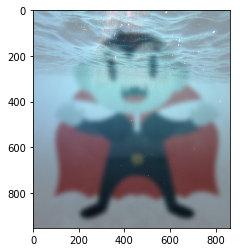

In [150]:
blended = Image.blend(im1, water, 0.5)
plt.figure()
plt.imshow(blended)

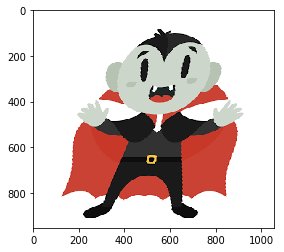

In [151]:
im2 = skew_image(im, 0.2)
plt.figure()
plt.imshow(im2)

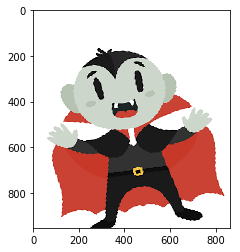

In [166]:
im3 = create_perspective(im, 3)
plt.figure()
plt.imshow(im3)

In [167]:
blended = Image.blend(im3, water, 0.7)
plt.figure()
plt.imshow(blended)

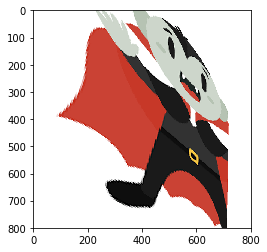

In [210]:
im4 = distort_image(im, 1, 90, 800)
plt.figure()
plt.imshow(im4)

In [202]:
blended = Image.blend(im4, water, 0.7)
plt.figure()
plt.imshow(blended)

ValueError: images do not match

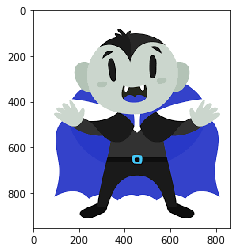

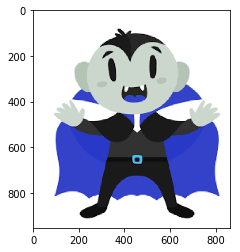

In [179]:
src = cv2.imread('Vamp.png', cv2.IMREAD_UNCHANGED)
dst = cv2.GaussianBlur(src, (5, 5), 0)
plt.figure()
plt.imshow(src)
plt.figure()
plt.imshow(dst)